## Dirichlet Mixture Prior for NeuroAlign

#### Problems: 
- The true probability distribution of a column is only poorly estimated by the relative frequencies $\frac{n_i}{n}$ where $n_i$ is the count of amino acid $i$ and $n=\sum_i n_i$, especially if $n$ is small (which is the case when training NeuroAlign due to hardware constraints). 
- If each column predicts its own amino acid distribution, beam search (commonly done in natural language processing) can not be applied when doing autoregressive inference since the output is not expected to agree on a single class (or amino acid).

#### Remedy:

Model the amino acid distribution of each column by a mixture of Dirichlets (Using Dirichlet mixture priors to derive hidden Markov models for protein families, Brown et al., 1993) i.e. a distribution of the form:

$$q_1 P_1 \dots q_k P_k$$

where $P_j$ are Dirichlet densities and $q_j$ are mixture coefficients that sum to 1.

Intuitively this models $k$ "fundamental" amino acid distributions. Observed amino acids counts in a alignment column can be converted to a posterior probability distribution over the amino acid alphabet given the counts. They can also be soft clustered to the components of the Dirichlet mixture (i.e. which component(s) are most probably the ground truth of the observed counts). This framework obviously solves the first problem mentioned above. It also has potential to solve the second one:

Assume NeuroAlign predicts an alignment column given sequences and previously predicted columns, i.e. $P(C_i | S, C_{i-1}, \dots, C_1)$. Especially the prediction of the very first column is crutial. Ideally, to implement something like beam search, we would like to have some candidates for the next column together with probabilities instead of a single prediction of a distribution. Brainstorming:

- Maybe the Dirichlet mixture can be used to soft cluster a predicted column to the components of the mixture. Then the underlying distributions of the $m$ most likely components given the predicted column can provide candidates for a beam search.

- The model could be rewritten such that it predicts a distribution over $k$ instead of the amino acids.

In [1]:
# uncomment below when using tf 2.3  
import sys
!{sys.executable} -m pip install tensorflow_probability==0.11.0

# uncomment below when using tf 2.4 
#import sys
#!{sys.executable} -m pip install tensorflow_probability

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers

A Dirichlet mixture prior is has (alphabet_size + 1) * $k$ parameters. Each of the $k$ components has one parameter for each symbol in the alphabet and one additional mixture coefficient. 

Below, we use a pretrained mixture (https://compbio.soe.ucsc.edu/dirichlets/dist.20comp) with $k=20$ components. 

In [2]:
ALPHABET = "A C D E F G H I K L M N P Q R S T V W Y".split()

q = []
alpha = []

k = 20

with open("dirichlet_20comp.txt", "r") as file:
    content = file.readlines()
    for line in content:
        if line[:8] == "Mixture=":
            q.append(float(line[9:]))
        elif line[:6] == "Alpha=":
            alpha.append([float(a) for a in line[7:].split()][1:])

q = np.array(q, dtype=np.float32) 
alpha = np.array(alpha, dtype=np.float32) 

print(q.shape) # k
print(alpha.shape) # k x len(alphabet)

(20,)
(20, 20)


Given the weights of a Dirichlet mixture prior, we can implement some useful methods.

- Posterior amino acid probabilities given observed counts. Takes as input a batch of count vectors corresponding to the columns of a MSA. It outputs a posterior probability $\hat{p}_i$ for each amino acid i.

- Posterior component probabilities $P(j|count)$ for components $j = 1,\dots,k$ and a count vector.

Formulas can be found in the paper (Using Dirichlet mixture priors to derive hidden Markov models for protein families, Brown et al., 1993).

In [3]:
class DirichletMixturePrior():
    def __init__(self, q, alpha):
        super(DirichletMixturePrior, self).__init__()
        # Dirichlet parameters > 0
        self.alpha = tf.constant(alpha)
        
        # mixture coefficients that sum to 1
        self.q = tf.constant(q)
        

    # in: n x alphabet_size count vectors 
    # out: n x k posterior probabilty distribution P(k | count)
    def posterior_component_prob(self, counts):
        total_counts = tf.reduce_sum(counts, axis=-1, keepdims=True)
        dist = tfp.distributions.DirichletMultinomial(total_counts, tf.expand_dims(self.alpha,0))
        probs = dist.prob(tf.expand_dims(counts, 1)) #P(count | p_k)
        mix_probs = tf.expand_dims(self.q,0) * probs
        return mix_probs / tf.reduce_sum(mix_probs, axis=-1, keepdims=True)

    
    # in: n x alphabet_size count vectors 
    #     output of self.posterior_component_prob(count vectors)
    # out: n x alphabet_size posterior amino acid probabilty distributions
    def posterior_amino_acid_prob(self, counts, posterior_component_prob):
        probs_unnormalized = counts + tf.matmul(posterior_component_prob, self.alpha)
        Z = tf.reduce_sum(probs_unnormalized, axis=-1, keepdims=True)
        return probs_unnormalized / Z
    
    
    # out: amino acid distribution of the j's mixture component
    def component_distributions(self):
        return self.alpha / tf.reduce_sum(self.alpha, axis=-1, keepdims=True)


dirichlet_mixture = DirichletMixturePrior(q, alpha)

np.random.seed(33)
tf.random.set_seed(33)

# count vectors from a MSA
n = 7
samples = 30
draws = tf.random.categorical([np.random.dirichlet(alpha[0]) for _ in range(n)], samples)
counts = np.zeros((n, len(ALPHABET)), dtype=np.float32)
for i in range(len(ALPHABET)):
    counts[:,i] = np.sum(draws == i, axis=-1)

posterior_component_prob = dirichlet_mixture.posterior_component_prob(counts)
posterior_amino_acid_prob = dirichlet_mixture.posterior_amino_acid_prob(counts, posterior_component_prob)
component_distributions = dirichlet_mixture.component_distributions()

Each component of the mixture is a Dirichlet distribution with concentrations $\alpha_1, \dots, \alpha_{20} > 0$. Amino acid probabilities are then simply $\frac{\alpha_i}{\alpha}$ with $\alpha=\sum_i \alpha_i$.

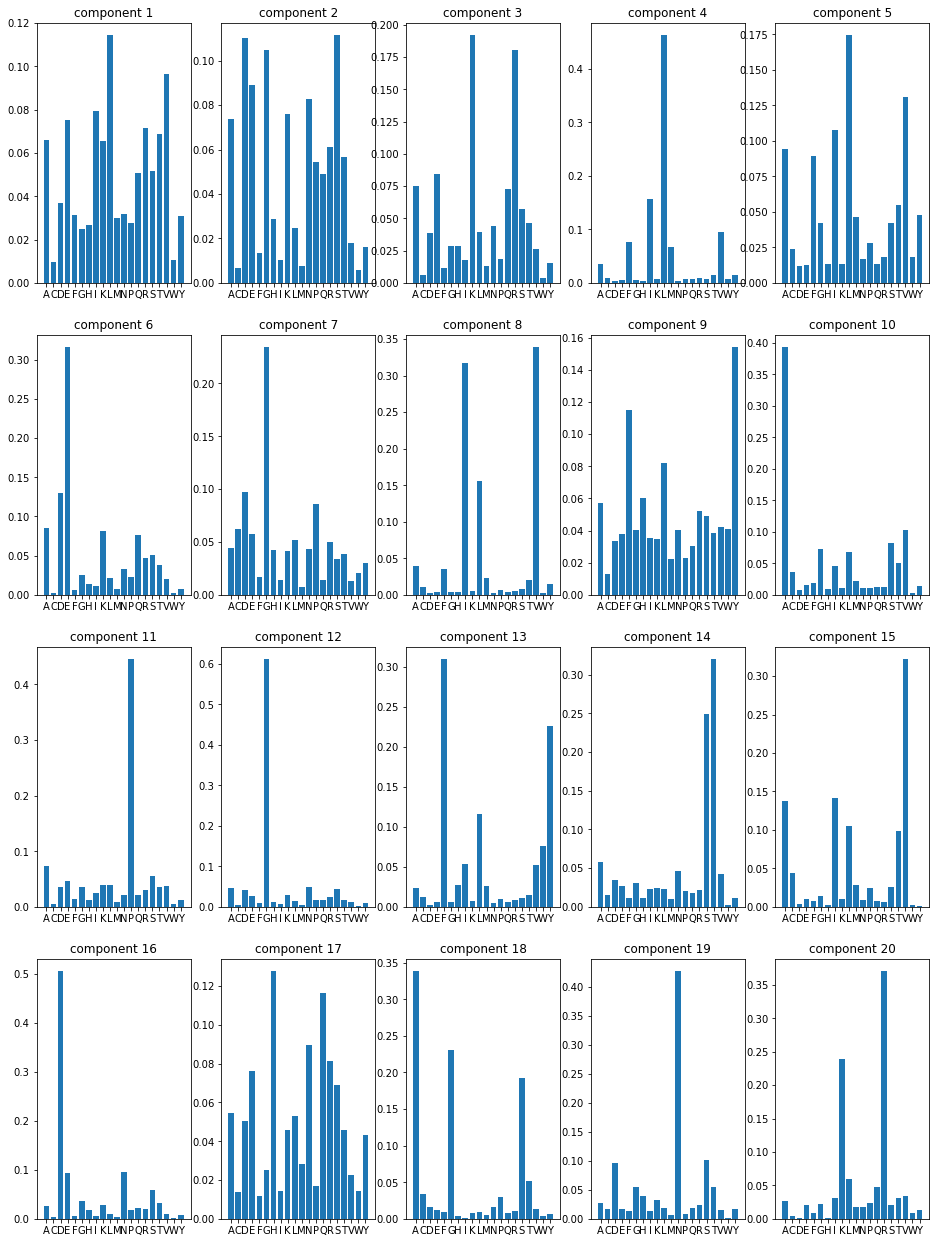

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 22)

num_rows = 4
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols)
for i,ax in enumerate(axes):
    for j,a in enumerate(ax):
        #a.set_ylim((0,1))
        a.bar(ALPHABET, component_distributions[i*num_cols+j])
        a.set_title("component "+str(i*num_cols+j+1))

plt.show()
#plt.savefig("results/component_distributions.pdf", bbox_inches='tight')

The Dirichlet mixture can be understood as a (soft) clustering of observed count vectors to the component distributions. The prior is pretty certain that the underlying distribution of the count vector below is component 1 (which was in fact used to sample it). This probability increases and decreases with the total count of observed residues (30 in this case).

In [5]:
print("Probabilities that underlying distribution of this count vector")
print(counts[0])
print("with",np.sum(counts[0]), "residues observed")
print("corresponds to the j'th component of the mixture:")
print(posterior_component_prob[0].numpy())

Probabilities that underlying distribution of this count vector
[2. 1. 1. 2. 3. 1. 1. 1. 1. 2. 2. 1. 2. 0. 0. 5. 2. 2. 0. 1.]
with 30.0 residues observed
corresponds to the j'th component of the mixture:
[9.09440219e-01 1.03964489e-02 3.92426045e-05 3.32019578e-10
 6.48063868e-02 2.67434484e-06 0.00000000e+00 7.50442972e-11
 1.50524294e-02 8.38745691e-05 1.14684175e-04 1.92201699e-09
 4.28698655e-14 6.39328719e-05 3.30529142e-13 2.54086552e-09
 4.82630776e-11 1.99802621e-15 9.58445128e-08 3.59431523e-16]


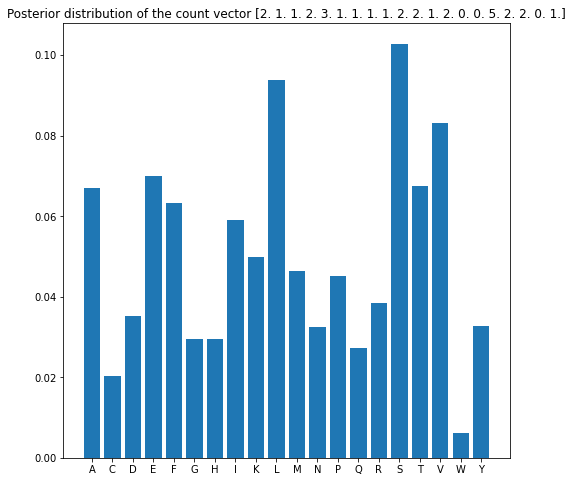

In [6]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.bar(ALPHABET, posterior_amino_acid_prob[0])
plt.title("Posterior distribution of the count vector " + str(counts[0]))
plt.show()